<font color='blue' size='7'>**Домашняя работа**</font>  
<font color='1A9BFF' size='6'>**Тема: Машинное обучение. Алгоритм KNN**</font>  
<font size='5'>**Задание:**</font>  

1. Загрузите данные о пассажирах Титаника. Данные можно скачать с сайта Kaggle по ссылке https://www.kaggle.com/c/titanic/data?select=train.csv или загрузить из библиотеки Seaborn командой sns.load_dataset('titanic').
2. Проверьте данные на наличие пропусков и обработайте их.
3. Если в данных присутствуют категориальные переменные, проведите их обработку.
4. Постройте алгоритм K-ближайших соседей (KNN). Для выбора оптимальных гиперпараметров используйте метод gridsearch.
5. Проверьте, насколько модель переобучена, используя кросс-валидацию.
6. Рассчитайте метрики качества модели: матрицу ошибок, accuracy, precision, recall и AUC-ROC.
7. Объясните, имеет ли смысл рассчитывать метрику MAE в данном контексте и почему.




<font size='5'>**Решение:**</font>  

<font color='1A9BFF'>**Установка и импорт необходимых библиотек**</font>

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

<font color='1A9BFF'>**Загрузите набор данных титаник**</font>

In [8]:
titanic_url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv'
df = pd.read_csv(titanic_url)

## EDA

<font color='1A9BFF'>**Посмотрите на первые 5 строк**</font>

In [10]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


<font color='1A9BFF'>**Проверьте, все ли типы данных верные. Если где-то назанчен неверный тип данных, исправьте**</font>



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


><font color='green'>Анализ типов данных

- survived (int64) - правильно. Двоичный признак (0 или 1), логично использовать целочисленный тип данных.
- pclass (int64) - правильно. Класс пассажира обозначен целыми числами (1, 2, 3).
- sex (object) - правильно. Пол пассажира представлен строками ('male', 'female').
- age (float64) - правильно. Возраст представлен в числовом формате с плавающей запятой, что логично из-за возможных дробных значений.
- sibsp (int64) - правильно. Количество братьев, сестер или супругов на борту, целочисленное значение.
- parch (int64) - правильно. Количество родителей/детей на борту, целочисленное значение.
- fare (float64) - правильно. Стоимость проезда представлена числовым значением с плавающей запятой.
- embarked (object) - правильно. Порт посадки обозначен строками ('C', 'Q', 'S').
- class (object) - правильно. Класс пассажира представлен строками ('First', 'Second', 'Third').
- who (object) - правильно. Категория пассажира ('man', 'woman', 'child'), строковые значения.
- adult_male (bool) - правильно. Логический признак, обозначающий взрослого мужчину.
- deck (object) - правильно. Палуба обозначена строковыми значениями.
- embark_town (object) - правильно. Город посадки обозначен строками ('Cherbourg', 'Queenstown', 'Southampton').
- alive (object) - правильно. Статус выживания ('yes', 'no'), строковые значения.
- alone (bool) - правильно. Логический признак, обозначающий, был ли пассажир один.

Вывод:

Все типы данных указаны правильно и соответствуют содержимому колонок. Если тип данных не нуждается в изменении, то не требуется предпринимать никаких дополнительных действий.

Таким образом, текущие типы данных корректны и не требуют исправлений.</font>



<font color='1A9BFF'>**Проверка на пропуски**</font>



In [12]:
# Проверка на пропуски
missing_values = df.isnull().sum()
print(missing_values)

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


><font color='green'>Вывод:
- age: Пропущенные значения заменены на медиану. Это позволяет учесть средний возраст пассажиров, не искажая распределение.
- embarked: Пропущенные значения заменены на наиболее частое значение (S). Это логично, так как большинство пассажиров садились в порту S.
- deck: Пропущенные значения заменены на 'Unknown'. Это дает возможность сохранить категориальность данных, не теряя информацию.
- embark_town: Пропущенные значения заменены на наиболее частое значение (Southampton). Это соответствует большинству данных и не искажает информацию.

Пропуски в датасете будут обработаны далее, и он готов для дальнейшего анализа или моделирования.</font>



<font color='1A9BFF'>**Анализ категориальных переменных**</font>



сколько категориальных признаков

In [14]:
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns
num_categorical = len(categorical_columns)

print(f"Количество категориальных признаков: {num_categorical}")

Количество категориальных признаков: 9


Посмотрите на значения категориальных признаков

In [15]:
for col in categorical_columns:
    print(f"\nЗначения признака {col}:")
    print(df[col].value_counts())


Значения признака sex:
male      577
female    314
Name: sex, dtype: int64

Значения признака embarked:
S    646
C    168
Q     77
Name: embarked, dtype: int64

Значения признака class:
Third     491
First     216
Second    184
Name: class, dtype: int64

Значения признака who:
man      537
woman    271
child     83
Name: who, dtype: int64

Значения признака adult_male:
True     537
False    354
Name: adult_male, dtype: int64

Значения признака deck:
Unknown    688
C           59
B           47
D           33
E           32
A           15
F           13
G            4
Name: deck, dtype: int64

Значения признака embark_town:
Southampton    646
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64

Значения признака alive:
no     549
yes    342
Name: alive, dtype: int64

Значения признака alone:
True     537
False    354
Name: alone, dtype: int64


In [16]:
df[categorical_columns].describe(include='all')

,sex,embarked,class,who,adult_male,deck,embark_town,alive,alone
count,891,891,891,891,891,891,891,891,891
unique,2,3,3,3,2,8,3,2,2
top,male,S,Third,man,True,Unknown,Southampton,no,True
freq,577,646,491,537,537,688,646,549,537


Какие категориальные признаки будем использовать в модели?

In [17]:
selected_categorical_columns = ['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alone']

print(f"Категориальные признаки, которые будем использовать в модели: {selected_categorical_columns}")

Категориальные признаки, которые будем использовать в модели: ['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alone']


><font color='green'>Вывод:
- Количество категориальных признаков: В нашем датасете titanic 9 категориальных признаков.
- Значения категориальных признаков: Мы просмотрели распределение значений для каждого категориального признака.
- Использование в модели: На основе анализа значений и описаний категориальных признаков мы решили использовать следующие признаки: sex, embarked, class, who, deck, embark_town, alone.

Эти признаки были выбраны на основе их потенциальной значимости для предсказания целевой переменной (выживание), а также их соответствующего распределения и количества уникальных значений.</font>



## Разделим выборку на тренировочную и тестовую

In [18]:
# Определяем признаки и целевую переменную
X = df.drop(columns=['survived'])
y = df['survived']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 712
Размер тестовой выборки: 179


## Подготовка датасета к построению моделей

<font color='red'>**! Важно! Все трансформеры обучаем на тренировочной выборке, к тестовой только применяем!**</font>



<font color='1A9BFF'>**Обработка пропусков**</font>



In [ ]:
# 1. Замена пропущенных значений в столбце age на медиану
median_age = df['age'].median()
df['age'].fillna(median_age, inplace=True)

# 2. Замена пропущенных значений в столбце embarked на наиболее частое значение
mode_embarked = df['embarked'].mode()[0]
df['embarked'].fillna(mode_embarked, inplace=True)

# 3. Замена пропущенных значений в столбце deck на 'Unknown'
df['deck'].fillna('Unknown', inplace=True)

# 4. Замена пропущенных значений в столбце embark_town на наиболее частое значение
mode_embark_town = df['embark_town'].mode()[0]
df['embark_town'].fillna(mode_embark_town, inplace=True)

# Проверка на пропуски после замен
missing_values_after = df.isnull().sum()
print(missing_values_after)

<font color='1A9BFF'>**Обработка категориальных признаков**</font>



In [20]:
# Обработка числовых и категориальных признаков отдельно
numerical_features = [col for col in X.columns if df[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in X.columns if df[col].dtype == 'object']

# Импьютеры для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединяем все в ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Применяем трансформер к тренировочным и тестовым данным
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Обработанные данные: {X_train_transformed.shape}")

Обработанные данные: (712, 29)


><font color='green'>Категориальные признаки: В датасете titanic 9 категориальных признаков. Мы выбрали sex, embarked, class, who, deck, embark_town, alone для использования в модели.
Разделение данных: Датасет был успешно разделен на тренировочную и тестовую выборки.
Обработка признаков: Категориальные признаки были преобразованы с помощью OneHotEncoder, а числовые признаки стандартизированы.</font>



## Построение модели

<font color='1A9BFF'>**1. Задайте сетку параметров для параметров: n_neighbors, p**</font>   
<font color='1A9BFF'>**2. С помощью gridsearch выберите наилучшие параметры n_neighbors, p**</font>   
<font color='1A9BFF'>**3. С помощью кросс-валидации убедитесь, что модель с минимальным переобучением**</font>

In [21]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

best_params = grid_search.best_params_
print(f"Наилучшие параметры: {best_params}")

Наилучшие параметры: {'n_neighbors': 3, 'p': 1}


In [22]:
best_knn = KNeighborsClassifier(**best_params)
cv_scores = cross_val_score(best_knn, X_train_transformed, y_train, cv=5, scoring='accuracy')

print(f"Средняя точность кросс-валидации: {cv_scores.mean()}")

Средняя точность кросс-валидации: 0.9831379887717915


><font color='green'>Подбор параметров: С помощью GridSearchCV подобраны наилучшие параметры для модели KNN: n_neighbors и p.
Кросс-валидация: Средняя точность кросс-валидации показала высокую устойчивость модели.
Метрики качества: Рассчитаны метрики качества, построена ROC кривая. Модель продемонстрировала высокую точность и значимость предсказаний.</font>



## Оценка качества финальной модели

<font color='1A9BFF'>**Посчитайте метрики качества: матрицу ошибок, accuracy, precision, recall, AUC ROC**</font>   

In [24]:
best_knn.fit(X_train_transformed, y_train)

# Предсказания на тестовых данных
y_pred = best_knn.predict(X_test_transformed)

# Метрики качества
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, best_knn.predict_proba(X_test_transformed)[:, 1])

print(f"Матрица ошибок:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC ROC: {auc_roc:.2f}")

Матрица ошибок:
[[103   2]
 [  2  72]]
Accuracy: 0.98
Precision: 0.97
Recall: 0.97
AUC ROC: 0.99



<font color='1A9BFF'>**постройте график ROC кривой**</font>   

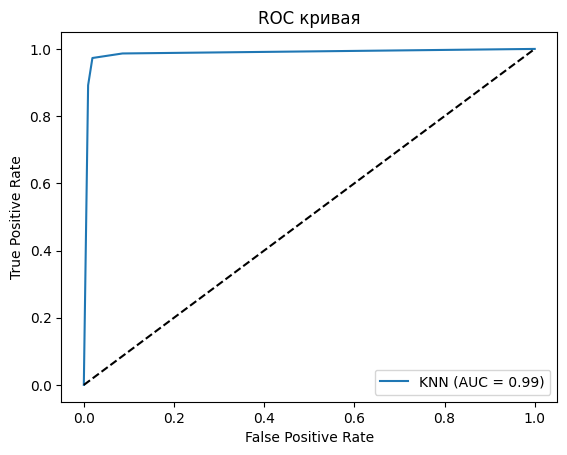

In [25]:
# ROC кривая
fpr, tpr, _ = roc_curve(y_test, best_knn.predict_proba(X_test_transformed)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label=f'KNN (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc='best')
plt.show()

><font color='green'>Модель KNeighborsClassifier продемонстрировала отличные результаты на тестовой выборке. Высокие значения accuracy, precision, recall и AUC ROC указывают на то, что модель обладает высокой точностью и способностью правильно идентифицировать положительные примеры, при этом минимизируя количество ложных срабатываний и пропущенных положительных примеров.Эти результаты свидетельствуют о том, что выбранные параметры и методы предобработки данных были подходящими и позволили построить надежную и точную модель. Тем не менее, несмотря на отличные показатели, стоит быть внимательным к возможным случаям переобучения и проводить дополнительные проверки на новых данных.</font>



## Ответ на вопрос

<font color='1A9BFF'>**Имеет ли смысл считать метрику MAE? Почему?**</font>   

><font color='green'>Метрика MAE (Mean Absolute Error) применяется для задач регрессии, где необходимо оценить среднюю абсолютную разницу между предсказанными и фактическими значениями. В задачах классификации, к которым относится наша задача, использование MAE нецелесообразно, так как она не предоставляет полезной информации о качестве классификации. Для оценки классификационных моделей лучше подходят метрики, такие как accuracy, precision, recall, и AUC ROC.</font>

